In [1]:
# **1. Introduction:**
# The data sets used in this analysis are composed of 13 features and 891 instances for training, and 418 instances for testing. The features such as survival, ticket class, sex, age in years, the number of siblings/spouse, the number of parents/children, ticket number, passenger fare, cabin number, and Port of Embarkation are included in the data set.
# 
# This notebook is designed to analyze what sorts of people were likely to survive and predict which passengers survived the tragedy. Before starting the analysis, I hypothesized that female or young passengers were more likely to survive. I also assumed that features such as PassengerID, Name of passengers, ticket number, and cabin number have no effect on survival. 

# **2. Methodology:**
# 
# - Import libraries and Load dataset
# 
# - Reduce data dimension by eliminating irrelevent features
# 
# - Pre-processing
# 
#     - Check and Impute missing cases
# 
#     - Discretization via Binning
# 
#     - Convert Discrete Features into Binary
# 
#     - Convert categorical features into numeric
# 
# - Analyze features with visualization
# 
# - Validation Testing and Prediction
# 
#     - Split data into training and validation sets
# 
#     - Decision Tree Classification
# 
#     - Prediction using Testing set

# **3. Analysis, Results, and Findings**
# 
# **3.1 Import Libraries and Load dataset**

In [2]:
## Import warnings. 
import warnings
warnings.filterwarnings("ignore") 

## Import analysis modules
import pandas as pd
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc

## Import visualization modules
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

C:\Users\adars\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
## Read in file
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')


## Basic information about the training set
train_original.info()


## Basic information about the testing set
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [4]:
# **3.2 Reduce data dimension by eliminating irrelevent features**
# 
# I assumed that features such as PassengerID, Name of passengers, ticket number, and cabin number are irrelevant or insignificant in this analysis, thus I decided to exclude them.

# Exclude some features to reduce data dimension
train=train_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test=test_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
total = [train,test]

train.shape, test.shape

((891, 8), (418, 7))

In [5]:
# **Dependent variable**: Survived
# 
# **Predictors**:
# 
# 1. Numerical
# 
#     - Age: age in years
# 
#     - Fare: Passenger fare
# 
#     - SibSp: # of siblings / spouse aboard the Titanic
# 
#     - Parch: # of parents / children aboard the Titanic
# 
# 3. Categorical
# 
#      - Pclass: Ticket Class (1st=1, 2nd=2, 3rd=3)
# 
#      - Sex: male, female
# 
#      - Embark: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# **3.3 Preprocessing**
# 
# - Check and Impute missing cases
# 
# - Discretization via binning
# 
# - Convert Discrete Features into Binary
# 
# - Convert categorical features to numeric

# **Training Set: Check and Impute missing cases**

In [6]:
## Missing cases for training set
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
## Age missing cases
train[train['Age'].isnull()].head()


## Distribution of Age, condition = Pclass
train[train.Pclass==1].Age.plot(kind='kde', color='r', label='1st class')
train[train.Pclass==2].Age.plot(kind='kde', color='b', label='2nd class')
train[train.Pclass==3].Age.plot(kind='kde', color='g',label='3rd class')
plt.xlabel('Age')
plt.legend(loc='best')
plt.grid()

In [8]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [9]:
# According to the distribution for "Age" feature, the median age for passengers deviates depending on three different ticket classes. Thus, we may replace missing cases with the median age value for each ticket class.

In [10]:
## Create function to replace NaN with the median value for each ticket class
def fill_missing_age(dataset):
    for i in range(1,4):
        median_age=dataset[dataset["Pclass"]==i]["Age"].median()
        dataset["Age"]=dataset["Age"].fillna(median_age)
        return dataset

train = fill_missing_age(train)

In [11]:
## Embarked missing cases 
train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [12]:
## Create Barplot 
sns.barplot(x="Embarked", y="Fare", hue="Sex", data=train)

In [13]:
# Considering Sex=female and Fare=80, Ports of Embarkation (Embarked) for two missing cases can be assumed to be Cherbourg (C).

In [14]:
## Replace missing cases with C
train["Embarked"] = train["Embarked"].fillna('C')

In [15]:
# **Testing Set: Check and Impute missing cases**

In [16]:
## Missing cases for testing set
test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [17]:
## Age missing cases
test[test['Age'].isnull()].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
10,3,male,NaN,0,0,7.8958,S
22,1,female,NaN,0,0,31.6833,S
29,3,male,NaN,2,0,21.6792,C
33,3,female,NaN,1,2,23.4500,S
36,3,female,NaN,0,0,8.0500,S


In [18]:
## Distribution of Age, condition = Pclass
test[test.Pclass==1].Age.plot(kind='kde', color='r', label='1st class')
test[test.Pclass==2].Age.plot(kind='kde', color='b', label='2nd class')
test[test.Pclass==3].Age.plot(kind='kde', color='g',label='3rd class')
plt.xlabel('Age')
plt.legend(loc='best')
plt.grid()

In [19]:
# With the same reason above, we may replace missing cases with the median age value for e

In [20]:
## Replace missing cases with the median age for each ticket class.
test = fill_missing_age(test)

In [21]:
## Fare missing cases 
test[test['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60.5,0,0,NaN,S


In [22]:
## Create function to replace NaN with the median fare with given conditions
def fill_missing_fare(dataset):
    median_fare=dataset[(dataset["Pclass"]==3) & (dataset["Embarked"]=="S")]["Fare"].median()
    dataset["Fare"]=dataset["Fare"].fillna(median_fare)
    return dataset

test = fill_missing_fare(test)

In [23]:
## Re-Check for missing cases
train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [24]:
test.isnull().any()

Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [25]:
# **Discretization via binning**
# 
# In this section, I transferred two continuous features (Age and Fare) into discrete counterparts. 

In [26]:
## Boxplot for Age
sns.boxplot(x=train["Survived"], y=train["Age"])

In [27]:
## discretize Age feature
for dataset in total:
    dataset.loc[dataset["Age"] <= 9, "Age"] = 0
    dataset.loc[(dataset["Age"] > 9) & (dataset["Age"] <= 19), "Age"] = 1
    dataset.loc[(dataset["Age"] > 19) & (dataset["Age"] <= 29), "Age"] = 2
    dataset.loc[(dataset["Age"] > 29) & (dataset["Age"] <= 39), "Age"] = 3
    dataset.loc[(dataset["Age"] > 29) & (dataset["Age"] <= 39), "Age"] = 3
    dataset.loc[dataset["Age"] > 39, "Age"] = 4
sns.countplot(x="Age", data=train, hue="Survived")

In [28]:
## Boxplot for Fare
sns.boxplot(x=train["Survived"], y=train["Fare"])

In [29]:
# The skewness of Fare feature is significantly high. Thus, I discretized the number of bin size based on the third quartile value; if the last bin starts with the third quartile value when bin size = n, then n number of bin will be selected. 

In [30]:
## discretize Fare
pd.qcut(train["Fare"], 8).value_counts()

(-0.001, 7.75]       140
(9.841, 14.454]      113
(69.488, 512.329]    112
(24.479, 31.0]       112
(7.91, 9.841]        111
(31.0, 69.488]       110
(14.454, 24.479]     110
(7.75, 7.91]          83
Name: Fare, dtype: int64

In [31]:
for dataset in total:
    dataset.loc[dataset["Fare"] <= 7.75, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.75) & (dataset["Fare"] <= 7.91), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 9.841), "Fare"] = 2
    dataset.loc[(dataset["Fare"] > 9.841) & (dataset["Fare"] <= 14.454), "Fare"] = 3   
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 24.479), "Fare"] = 4
    dataset.loc[(dataset["Fare"] >24.479) & (dataset["Fare"] <= 31), "Fare"] = 5   
    dataset.loc[(dataset["Fare"] > 31) & (dataset["Fare"] <= 69.487), "Fare"] = 6
    dataset.loc[dataset["Fare"] > 69.487, "Fare"] = 7    
    
sns.countplot(x="Fare", data=train, hue="Survived")

In [32]:
# **Convert Discrete Features into Binary**

In [33]:
## Countplot for the number of siblings/spouse
sns.countplot(x="SibSp", data=train, hue="Survived")

In [34]:
## Countplot for the number of parents/childrens
sns.countplot(x="Parch", data=train, hue="Survived")

In [35]:
# Since the majority of cases are zero for both discrete features, I converted them into binary format.

In [36]:
## Convert SibSp into binary feature
for dataset in total:
    dataset.loc[dataset["SibSp"]==0, "SibSp"]=0
    dataset.loc[dataset["SibSp"]!=0, "SibSp"]=1

sns.countplot(x="SibSp", data=train, hue="Survived")

In [37]:
## Convert Parch into binary feature
for dataset in total:
    dataset.loc[dataset["Parch"]==0, "Parch"]=0
    dataset.loc[dataset["Parch"]!=0, "Parch"]=1
    
sns.countplot(x="Parch", data=train, hue="Survived")


# **Convert categorical features to numeric**

In [38]:
## Scikit learn estimators require numeric features
sex = {'female':0,'male':1}
embarked = {'C':0,'Q':1,'S':2}   

In [39]:
## Convert categorical features to numeric using mapping function
for dataset in total:
    dataset['Sex'] = dataset['Sex'].map(sex)
    dataset['Embarked'] = dataset['Embarked'].map(embarked)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,2.0,1,0,0.0,2
1,1,1,0,3.0,1,0,7.0,0
2,1,3,0,2.0,0,0,2.0,2
3,1,1,0,3.0,1,0,6.0,2
4,0,3,1,3.0,0,0,2.0,2


In [40]:
# **3.4 Analyze features with visualization**
# 
# I calculated and visualized survival rate for each feature to see what sorts of people were likely to survive the tragedy. 

In [41]:
## total survival rate of train dataset
survived_cases=0
for i in range(891):
    if train.Survived[i]==1:
        survived_cases = survived_cases + 1

total_survival_rate = float(survived_cases)/float(891)

print('%0.4f' % (total_survival_rate))


# Total survival rate was 38.38%

0.3838


In [42]:
## Survival rate under each feature condition
def survival_rate(feature):
    rate = train[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by=[feature], ascending=True)
    sns.factorplot(x=feature, y="Survived", data=rate)

In [43]:
for feature in ["Age", "Fare", "SibSp", "Parch", "Sex", "Embarked", "Pclass"]:
    survival_rate(feature)


# - **Age**: As I expected from the beginning, young passengers (Age<=9) were more likely to survive than the elder. Age bin for passengers with the lowest survival rate was from 30 to 39, indicating that middle-age people sacrificed themselves when the tragedy occurred. 
# 
# 
# - **Fare / Pclass**: The survival rate significantly increased when passenger belonged to the first class. The bar graph below showed that fare and ticket class were closely related to each other. Therefore, we may explicitly assume that the rich were more likely to survive the tragedy. 
# 
# 
# - SibSp / Parch: The graphs of these two features were very similar; passengers with family were more likely to survive than those who came alone. 
# 
# 
# - **Sex**: As I expected from the beginning, the survival rate for female passengers were significantly higher than the one for male. 
# 
# 
# - Embarked: The survival rate graph showed that passengers who came from Cherbourg were more likely to survive. But I couldn't figure out the key relationship between survival rate and port of Embarkation. Further studies are required.

In [44]:
## Inter-relationship between Fare and Pclass
sns.countplot(x="Fare", data=train, hue="Pclass")

In [45]:
## Relationship between Embarked and other features
train.groupby(["Embarked"], as_index=False).mean()

,Embarked,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,0.558824,1.876471,0.558824,2.594118,0.347059,0.264706,4.458824
1,1,0.389610,2.909091,0.532468,2.701299,0.233766,0.103896,1.467532
2,2,0.336957,2.350932,0.684783,2.448758,0.319876,0.248447,3.453416


In [46]:
# **3.5 Validation Testing and Prediction**
# 
# - Split data into training and validation sets
# 
# - Decision Tree Classification
# 
# - Prediction using Testing set

# **Split data into testing and validation sets**

In [47]:
## Seperate input features from target feature
x = train.drop("Survived", axis=1)
y = train["Survived"]

In [48]:
## Split the data into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25,random_state=1)

In [49]:
## Take a look at the shape
x_train.shape, y_train.shape

# **Decision Tree Classification**

((668, 7), (668,))

In [77]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=1)

In [51]:
## Run 10 fold cross validation
cvs = cross_val_score(clf,x,y,cv=5)
print(cvs)

[ 0.79329609  0.77653631  0.83146067  0.80337079  0.84180791]


In [78]:
# import the training and test data
dftrain = pd.read_csv('train.csv', header=0)
dftest = pd.read_csv('test.csv', header=0)

# drop the columns we will not use
dftrain = dftrain.drop(['Name', 'Ticket', 'Cabin'], axis=1)
dftest = dftest.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# convert string values to dummy variables
dftrain['Sex'] = pd.Categorical(dftrain.Sex).labels
dftest['Sex'] = pd.Categorical(dftest.Sex).labels
dftrain['Embarked'] = pd.Categorical(dftrain.Embarked).labels
dftest['Embarked'] = pd.Categorical(dftest.Embarked).labels

# fill NaN
dftrain.fillna(method='ffill', inplace=True)
dftest.fillna(method='ffill', inplace=True)

# single decision tree
tree = DecisionTreeClassifier()
tree = tree.fit(dftrain.ix[:,'Pclass':], dftrain['Survived'])
dt_output = tree.predict(dftest.ix[:,'Pclass':])
df_dtout = pd.DataFrame(dftest['PassengerId'].values, columns=['PassengerId'])
df_dtout['Survived'] = dt_output

# save decision tree prediction:
df_dtout.to_csv('dt_prediciton.csv', index=False)

In [52]:
## Show cross validation score mean and std
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))


# The cross validation test result showed that accuracy of the model is 0.8070. Thus, we may conclude that 80.70% of cross-validation set tuples were correctly classified by this model.


Accuracy: 0.8093 (+/- 0.0483)


In [72]:
## Fit the model with data
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [54]:
## Accuracy
acc_decision_tree = round(clf.score(x_train, y_train), 4)
print("Accuracy: %0.4f" % (acc_decision_tree))

Accuracy: 0.9027


In [55]:
# We split the data into 75% training and 25% validation sets, and fitted the model. Based on this split, classifier accuracy of the model turned out to be 0.9027. Thus, we may conclude that 90.27% of validation set tuples were correctly classified by this model.

In [58]:
## Predict y given validation set
predictions = clf.predict(x_test)

In [59]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(y_test,predictions)

array([[115,  13],
       [ 34,  61]], dtype=int64)

In [60]:
## Precision
print("Precision: %0.4f" % precision_score(y_test, predictions))


# The precision is 0.8310. Thus, we may conclude that 83.10% of tuples that the classifier labeled as positive are actually positive by this model.

Precision: 0.8243


In [61]:
## Recall score
print("Recall: %0.4f" % recall_score(y_test, predictions))


# The recall is 0.6211. Thus, we may conclude that 62.11% of real positive tuples were classified by the decision tree classifier.

Recall: 0.6421


In [62]:
## Print classification report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.77      0.90      0.83       128
          1       0.82      0.64      0.72        95

avg / total       0.79      0.79      0.78       223



In [63]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, predictions)
roc_auc = auc(fp, tp)

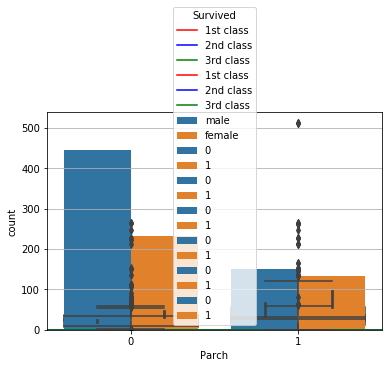

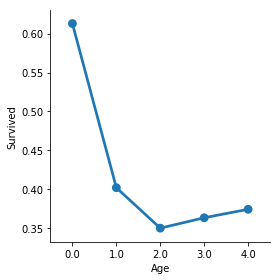

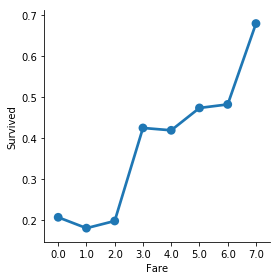

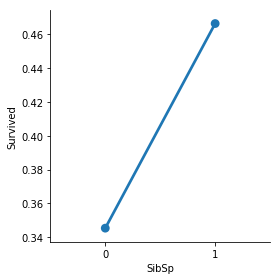

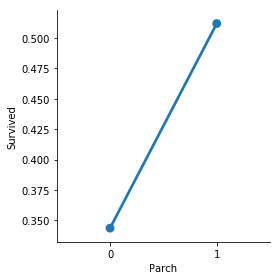

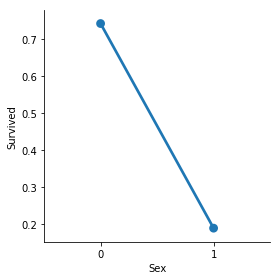

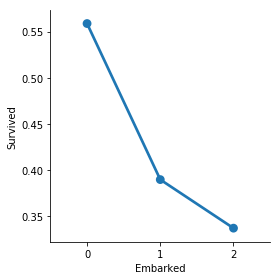

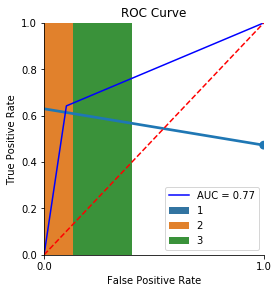

In [64]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

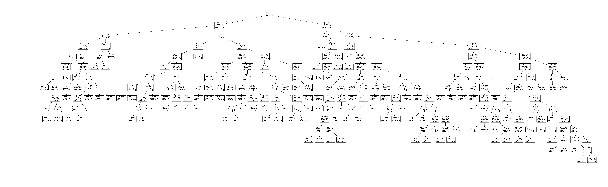

In [66]:
#Plotting Decision Tree graph ,Also saved image snippet of a tree
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
from sklearn import tree
#from graphviz import *

import matplotlib.image as mpimg
import pydotplus

dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile)
dotfile.close()
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_file("dtree2.dot")
graph.write_png('test.png')
img=mpimg.imread('test.png')
fig = plt.figure(figsize=(10, 10)) 
plt.axis("off")
plt.imshow(img, cmap = plt.cm.binary,
           interpolation="nearest")
plt.show()